In [219]:
! pip install pandas unidecode seaborn matplotlib

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached contourpy-1.3.1-cp312-cp312-macosx_11_0_arm64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.8-cp312-cp312-macosx_11_0_arm64.whl.metadata (6.2 kB)
  Using cached pillow-11.1.0-cp312-cp312-macosx_11_0_arm64.whl.metadata (9.1 kB)
  Using cached pyparsing-3.2.1-py3-none-any.whl.metadata (5.0 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 74.1 MB/s eta 0:00:00
Using cached contourpy-1.3.1-cp312-cp312-macosx_11_0_arm64.whl (255 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 60.2 MB/s eta 0:00:00
Using cached kiwisolver-1.4.8-cp312-cp312-macosx_11_0_arm64.whl (65 kB)
Using cached pillow-11.1.0-cp312-cp312-macosx_11_0_arm64.whl (3.1 MB)
Using cached pyparsing-3.2.1-py3-none-any.whl (107 kB)


In [390]:
import pandas as pd
from unidecode import unidecode

In [391]:
# load the data
df = pd.read_csv('menus.csv')

In [392]:
# convert prices to numeric
df['price'] = df['price'].apply(lambda x: pd.to_numeric(x[1:], errors='coerce'))

In [393]:
non_numeric_count = df['price'].isna().sum()
f"Number of non-numerical values in 'price' column: {non_numeric_count}"

"Number of non-numerical values in 'price' column: 19"

In [394]:
# Remove the non-numerical values
df = df.dropna(subset=['price'])

In [395]:
zero_count = (df['price'] == 0).sum()
f"Number of 0s in 'price' column: {zero_count}"

"Number of 0s in 'price' column: 7"

In [396]:
# Remove 0s, since these are free stuff that are generally included anywhere
df = df[df['price'] != 0]

In [397]:
# Filter out any non-standard characters for easier matching with our restaurants dataset
df['name'] = (df['name']
              .apply(unidecode)
              .replace(r'[^a-zA-Z0-9\- ]', '', regex=True)
              .replace(r' +', ' ', regex=True)
              .str.strip())

In [398]:
# Clarify that the price is Uber local_price
df = df.rename(columns={'price': 'uber_price'})

In [399]:
df.head()

,restaurant,name,uber_price
0,Nick The Greek - Davis,Chicken Gyro Pita,14.95
1,Nick The Greek - Davis,BeefLamb Gyro Pita,14.95
2,Nick The Greek - Davis,Falafel Pita,14.95
3,Nick The Greek - Davis,BeefLamb Gyro Pita,14.95
4,Nick The Greek - Davis,BeefLamb Gyro Pita Combo,19.75


In [400]:
# get the restaurant names so we match the correct menu item
df['restaurant'].unique()

array(['Nick The Greek - Davis', 'Jack in the Box (337 G St.)',
       'Local Kitchens - Davis', 'Wingstop (408 G ST)',
       'Blaze Pizza (212 F Street)'], dtype=object)

In [401]:
# now add all local restaurants
restaurants = [
  ('blaze', 'Blaze Pizza (212 F Street)'),
  ('jack_in_the_box', 'Jack in the Box (337 G St.)'),
  ('local_kitchens', 'Local Kitchens - Davis'),
  ('nick_the_greek', 'Nick The Greek - Davis'),
  ('wings', 'Wingstop (408 G ST)'),
]

new_dfs = []

for file_name, restaurant in restaurants:
  df1 = df[df['restaurant'] == restaurant]
  df2 = pd.read_csv(f'{file_name}.csv')
  df2 = df2.rename(columns={"Price": "local_price"})

  # local kitchens is in pennies
  if file_name == 'local_kitchens':
    df2['local_price'] = pd.to_numeric(df2['local_price'], errors='coerce') / 100

  # Filter out any non-standard characters for easier matching with our restaurants dataset
  df2['Name'] = (df2['Name']
                 .apply(unidecode)
                 .replace(r'[^a-zA-Z0-9\- ]', '', regex=True)
                 .replace(r' +', ' ', regex=True)
                 .str.strip())

  df1 = df1.merge(
    df2,
    left_on='name',
    right_on='Name',
    how='left',
    suffixes=('', ''),
  )

  new_dfs.append(df1)

df = pd.concat(new_dfs)
df.head()

,restaurant,name,uber_price,Category,Name,local_price,Description,Base Calories,Max Calories,Brand
0,Blaze Pizza (212 F Street),Feed The Family 5,53.00,What's Hot,Feed The Family 5,45.0,3 BYO 11-inch Pizzas + Your Choice any Two: En...,NaN,NaN,NaN
1,Blaze Pizza (212 F Street),Feed The Family 5,53.00,Digital Deals,Feed The Family 5,45.0,3 BYO 11-inch Pizzas + Your Choice any Two: En...,NaN,NaN,NaN
2,Blaze Pizza (212 F Street),Green Goddess Chop Salad - Side,8.53,What's Hot,Green Goddess Chop Salad - Side,7.19,This fresh and vibrant salad that's packed wit...,NaN,NaN,NaN
3,Blaze Pizza (212 F Street),Green Goddess Chop Salad - Side,8.53,Cheesy Breads & Salads,Green Goddess Chop Salad - Side,7.19,This fresh and vibrant salad that's packed wit...,NaN,NaN,NaN
4,Blaze Pizza (212 F Street),Green Goddess Chop Salad - Entree,13.41,What's Hot,Green Goddess Chop Salad - Entree,10.99,This fresh and vibrant salad that's packed wit...,NaN,NaN,NaN


In [402]:
f'There are {df['local_price'].isna().sum()} local restaurant prices missing'

'There are 52 local restaurant prices missing'

In [403]:
df[df['local_price'].isna()].head()

,restaurant,name,uber_price,Category,Name,local_price,Description,Base Calories,Max Calories,Brand
12,Blaze Pizza (212 F Street),Vegan Pizza 11-inch,19.95,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,Blaze Pizza (212 F Street),Vegetarian Pizza 11-inch,21.95,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67,Blaze Pizza (212 F Street),Coke Bottle 20oz591ml,4.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68,Blaze Pizza (212 F Street),Diet Coke Bottle 20oz591ml,3.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN
70,Blaze Pizza (212 F Street),Sprite Bottle 20oz591ml,4.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [404]:
# I inspected these values, and couldn't match them manually, so we will just drop them
df = df[~df['local_price'].isna()]

In [405]:
df = df.drop(columns=["Base Calories", "Max Calories", "Brand", "Name"])

In [406]:
df.head()

,restaurant,name,uber_price,Category,local_price,Description
0,Blaze Pizza (212 F Street),Feed The Family 5,53.00,What's Hot,45.0,3 BYO 11-inch Pizzas + Your Choice any Two: En...
1,Blaze Pizza (212 F Street),Feed The Family 5,53.00,Digital Deals,45.0,3 BYO 11-inch Pizzas + Your Choice any Two: En...
2,Blaze Pizza (212 F Street),Green Goddess Chop Salad - Side,8.53,What's Hot,7.19,This fresh and vibrant salad that's packed wit...
3,Blaze Pizza (212 F Street),Green Goddess Chop Salad - Side,8.53,Cheesy Breads & Salads,7.19,This fresh and vibrant salad that's packed wit...
4,Blaze Pizza (212 F Street),Green Goddess Chop Salad - Entree,13.41,What's Hot,10.99,This fresh and vibrant salad that's packed wit...


In [407]:
f'We now have {df.shape[0]} entries to compare'

'We now have 377 entries to compare'

In [408]:
# Convert the local_price col to numeric
df['local_price'] = pd.to_numeric(df['local_price'], errors='coerce')

f'There are {df['local_price'].isna().sum()} unsuccessful converted values'

'There are 0 unsuccessful converted values'

In [409]:
# Show the summary statistics for the different prices overall
df[['uber_price', 'local_price']].describe()

,uber_price,local_price
count,377.000000,377.000000
mean,12.033024,10.190743
std,8.630545,7.343377
min,0.490000,0.490000
25%,6.050000,5.100000
50%,10.490000,8.750000
75%,15.610000,13.990000
max,57.490000,49.990000


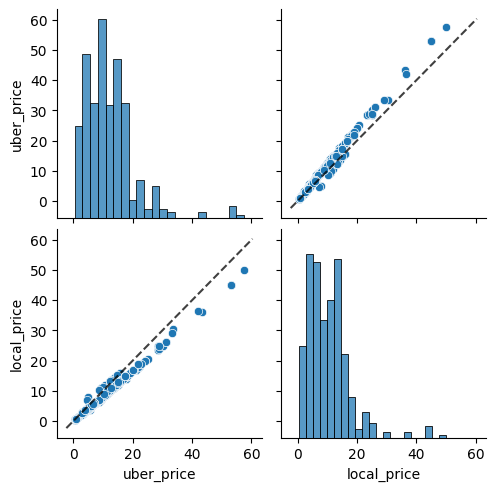

In [410]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the pairplot
g = sns.pairplot(df[['uber_price', 'local_price']])

# Add y = x dashed line to each subplot
for ax in g.axes.flat:
  if ax is not None:
    x_var = ax.get_xlabel()
    y_var = ax.get_ylabel()
    if x_var == '' or y_var == '':
      continue
    lims = [
      min(ax.get_xlim()[0], ax.get_ylim()[0]),  # Get lower limit
      max(ax.get_xlim()[1], ax.get_ylim()[1]),  # Get upper limit
    ]
    ax.plot(lims, lims, 'k--', alpha=0.75)

# Show the plot
plt.show()

In [411]:
df[df["local_price"] > df["uber_price"]].head()

,restaurant,name,uber_price,Category,local_price,Description
52,Blaze Pizza (212 F Street),Pesto Garlic Cheesy Bread,4.87,Cheesy Breads & Salads,7.99,"Our classic dough with shredded mozzarella, or..."
0,Jack in the Box (337 G St.),Big Smashed Jacktm Combo,15.61,What's New,15.78,Two 1/4lb smashed patties made w/ 100% seasone...
1,Jack in the Box (337 G St.),Big Smashed Jacktm Combo,15.61,Burger Combos,15.78,Two 1/4lb smashed patties made w/ 100% seasone...
7,Jack in the Box (337 G St.),12pc Smoke Show Smoky BBQ Crispy Boneless Wing...,15.61,What's New,15.78,12pc 100% all-white meat Crispy Boneless Wings...
8,Jack in the Box (337 G St.),12pc Smoke Show Smoky BBQ Crispy Boneless Wing...,15.61,Chicken Combos,15.78,12pc 100% all-white meat Crispy Boneless Wings...


In [412]:
# calculate the summary statistics for how much more people pay at Uber Eats
df['markup'] = (df['uber_price'] - df['local_price']) / df['local_price']
df[['markup']].describe()

,markup
count,377.000000
mean,0.190037
std,0.102564
min,-0.390488
25%,0.196000
50%,0.212500
75%,0.250227
max,0.467249


In [413]:
df.to_csv('data.csv')